## Set-up

In [135]:
import torch
from torch.utils.data import Dataset
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import string
import unicodedata


In [136]:
# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cpu


## Prepare and load Data

In [137]:
allowed_characters = string.ascii_letters + " .,;'"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [138]:
%run -i 'namesdataset.py'

-- Initiate Dataset declaration
-- Dataset declaration finalized


In [139]:
alldata = NamesDataset("../data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([5]), tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]]), 'Czech', 'Abl')


In [140]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


## Prepare model

In [141]:
%run -i './rnn.py'

-- Initiate model and training declaration
-- Finished model and training declaration


In [142]:
n_hidden = 128
dnn = DeepANN(n_letters, n_hidden, len(alldata.labels_uniq))
print(dnn)

DeepANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_deep_stack): Sequential(
    (0): Linear(in_features=57, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=18, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)


In [143]:
print('Pre-training sample output:')
input = lineToTensor('Albert')
output = dnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

Pre-training sample output:
tensor([[-3.0128, -2.7637, -2.8417, -2.8868, -2.9746, -3.0130, -2.7955, -2.7874,
         -2.8630, -2.9106, -2.8351, -2.9751, -2.9574, -2.9836, -2.7469, -2.8994,
         -2.9079, -2.9338]], grad_fn=<LogSoftmaxBackward0>)
('French', 14)


In [ ]:
start = time.time()
all_losses = train(dnn, train_set, n_epoch=50, learning_rate=0.15, report_every=5)
end = time.time()
print(f"training took {end-start}s")

training on data set with n = 17063
5 (19%): 	 average batch loss = 0.7858349609523236
10 (37%): 	 average batch loss = 0.6747929555649975
15 (56%): 	 average batch loss = 0.6074061459754504
20 (74%): 	 average batch loss = 0.5631836430643113
25 (93%): 	 average batch loss = 0.533002615628248
training took 71.54821157455444s


In [145]:
print('Post-training sample output:')

input = lineToTensor('Albert')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

Post-training sample output:
tensor([[-3.0424, -2.7761, -2.8326, -2.7770, -2.9690, -2.9729, -2.8705, -2.8821,
         -2.9022, -2.9692, -2.9319, -2.8713, -2.9936, -2.7764, -2.9781, -2.8422,
         -2.9045, -2.7932]], grad_fn=<LogSoftmaxBackward0>)
('Chinese', 1)


In [146]:
all_losses = np.array(all_losses)
all_losses

array([1.27618279, 0.99977636, 0.8910939 , 0.83086977, 0.78583496,
       0.75972836, 0.73021354, 0.7098785 , 0.68751616, 0.67479296,
       0.65572022, 0.64230992, 0.63363654, 0.62027511, 0.60740615,
       0.59918187, 0.58842413, 0.57769402, 0.57092018, 0.56318364,
       0.55840391, 0.54684791, 0.53996255, 0.534439  , 0.53300262,
       0.52409439, 0.51678901])

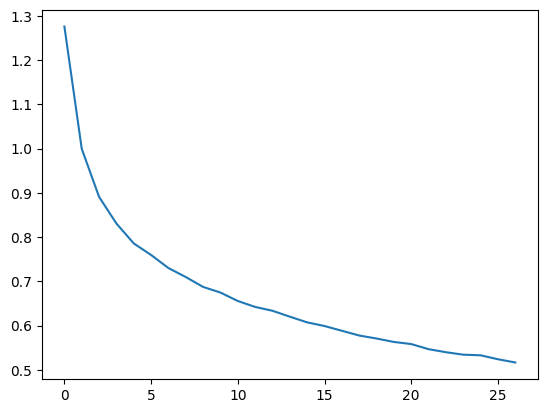

In [147]:
plt.figure()
plt.plot(all_losses)
plt.show()

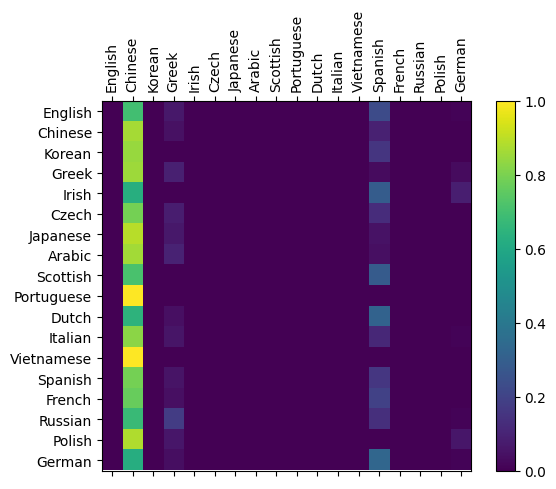

In [148]:
evaluate(rnn, test_set, classes=alldata.labels_uniq)